### In this checkpoint, you'll work on regression. Find a dataset and build a KNN regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter Notebook with your models. At the end, in a Markdown cell, write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your Notebook below.

### Imports

In [1]:
%reload_ext nb_black
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix


import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline



<IPython.core.display.Javascript object>

In [2]:
def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

<IPython.core.display.Javascript object>

### Data Exploration and Cleaning

In [3]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original"
names = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "year",
    "origin",
    "model",
]

df = pd.read_csv(data_url, sep="\s+", names=names)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,model
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


<IPython.core.display.Javascript object>

In [4]:
# df.info()

<IPython.core.display.Javascript object>

In [5]:
# Not many nulls, so dropping
df = df.dropna(subset=["mpg"])
df = df.dropna()

<IPython.core.display.Javascript object>

In [6]:
# Slice the cars' make from the model
df["make"] = df["model"].str.split(" ").str[0]

<IPython.core.display.Javascript object>

In [7]:
# Create an "other" column to reduce variables for OneHotEncoding
make_counts = df["make"].value_counts()
keep_models = make_counts[make_counts >= 5]
keep_makes = keep_models.index
df.loc[~df["make"].isin(keep_makes), "make"] = "other"

<IPython.core.display.Javascript object>

In [8]:
df = df.drop(columns="model")

<IPython.core.display.Javascript object>

### OLS model

In [9]:
X = df.drop(columns=["mpg", "make"])
y = df["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

<IPython.core.display.Javascript object>

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)


0.8274776052076003

<IPython.core.display.Javascript object>

In [11]:
model.score(X_test, y_test)

0.7912565395128666

<IPython.core.display.Javascript object>

In [12]:
print(model.intercept_)
print(model.coef_)

-17.050217741666717
[-0.51641359  0.01902367 -0.02604842 -0.00602022  0.0218826   0.7572995
  1.50779468]


<IPython.core.display.Javascript object>

In [13]:
y_pred = model.predict(X_test)

<IPython.core.display.Javascript object>

In [14]:
pred_df = X_test.copy()
pred_df["actual"] = y_test
pred_df["predicted"] = y_pred
pred_df

,cylinders,displacement,horsepower,weight,acceleration,year,origin,actual,predicted
63,4.0,91.0,70.0,1955.0,20.5,71.0,1.0,26.0,24.747011
78,3.0,70.0,97.0,2330.0,13.5,72.0,3.0,19.0,25.522748
322,4.0,151.0,90.0,3003.0,20.1,80.0,1.0,24.3,25.865213
188,4.0,91.0,53.0,1795.0,17.5,75.0,3.0,33.0,32.132209
316,4.0,98.0,76.0,2144.0,14.7,80.0,2.0,41.5,31.782636
...,...,...,...,...,...,...,...,...,...
192,4.0,98.0,79.0,2255.0,17.7,76.0,1.0,26.0,26.564901
312,4.0,151.0,90.0,2670.0,16.0,79.0,1.0,28.4,27.022929
73,8.0,304.0,150.0,3672.0,11.5,72.0,1.0,17.0,14.873161
374,6.0,225.0,85.0,3465.0,16.6,81.0,1.0,17.6,24.269748


<IPython.core.display.Javascript object>

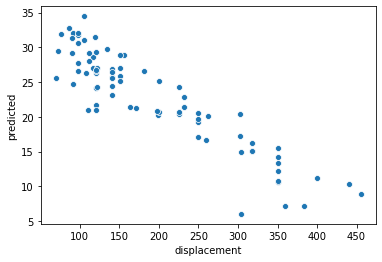

<IPython.core.display.Javascript object>

In [15]:
sns.scatterplot(x="displacement", y="predicted", data=pred_df)
plt.show()

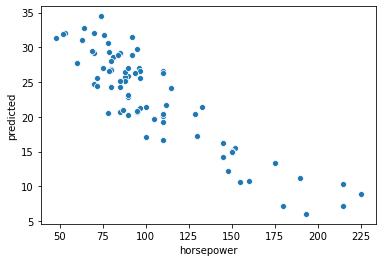

<IPython.core.display.Javascript object>

In [16]:
sns.scatterplot(x="horsepower", y="predicted", data=pred_df)
plt.show()

### KNN Model 

In [17]:
X = df.drop(columns=["mpg"])
y = df["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

<IPython.core.display.Javascript object>

In [18]:
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,year,origin,make
209,6.0,258.0,95.0,3193.0,17.8,76.0,1.0,amc
191,4.0,140.0,92.0,2572.0,14.9,76.0,1.0,other
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc
183,6.0,232.0,90.0,3211.0,17.0,75.0,1.0,amc
268,6.0,258.0,120.0,3410.0,15.1,78.0,1.0,amc


<IPython.core.display.Javascript object>

In [19]:
cat_cols = ["make", "origin"]
num_cols = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "year"]
drop_cats = ["ford", 1.0]

<IPython.core.display.Javascript object>

In [20]:
preprocessing = ColumnTransformer(
    [
        ("scale", StandardScaler(), num_cols),
        ("one_hot_encode", OneHotEncoder(drop=drop_cats), cat_cols),
    ]
)

<IPython.core.display.Javascript object>

In [21]:
pipeline = Pipeline(
    [
        # ("name of step", sklearn object with a fit method)
        ("preprocessing", preprocessing),
        #         ("pca", PCA()),
        ("knn", KNeighborsRegressor()),
    ]
)

<IPython.core.display.Javascript object>

In [22]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['cylinders', 'displacement',
                                                   'horsepower', 'weight',
                                                   'acceleration', 'year']),
                                                 ('one_hot_encode',
                                                  OneHotEncoder(drop=['ford',
                                                                      1.0]),
                                                  ['make', 'origin'])])),
                ('knn', KNeighborsRegressor())])

<IPython.core.display.Javascript object>

In [23]:
pipeline.score(X_train, y_train)

0.89689410622147

<IPython.core.display.Javascript object>

In [24]:
pipeline.score(X_test, y_test)

0.8380170227314471

<IPython.core.display.Javascript object>

In [26]:
grid = {
    "knn__n_neighbors": [1, 5, 10, 15, 20, 25, 50],
    "knn__weights": ["uniform", "distance"],
}

<IPython.core.display.Javascript object>

In [27]:
pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
pipeline_cv.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.0s finished


GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['cylinders',
                                                                          'displacement',
                                                                          'horsepower',
                                                                          'weight',
                                                                          'acceleration',
                                                                          'year']),
                                                                        ('one_hot_encode',
                                                                         OneHotEncoder(drop=['ford',
                                                       

<IPython.core.display.Javascript object>

In [28]:
pipeline_cv.best_params_

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

<IPython.core.display.Javascript object>

In [29]:
pipeline_cv.score(X_train, y_train)

1.0

<IPython.core.display.Javascript object>

In [30]:
pipeline_cv.score(X_test, y_test)

0.8363675197483369

<IPython.core.display.Javascript object>

In [31]:
y_pred = pipeline_cv.predict(X_test)

<IPython.core.display.Javascript object>

In [32]:
mae = np.mean(np.abs(y_test - y_pred))

<IPython.core.display.Javascript object>

In [33]:
mae

2.3028662738116803

<IPython.core.display.Javascript object>

In [34]:
mape = np.mean(np.abs((y_test - y_pred) / y_test))

<IPython.core.display.Javascript object>

In [35]:
mape

0.10207624120799194

<IPython.core.display.Javascript object>

The KNN model is with 2.3 mpg, or about 10% of the right answer